# Pyroomacoustics Demo

### dependencies:  pyroomacoustics, pysoundfile, samplerate

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import pyroomacoustics as pra
import soundfile

plt.rcParams['font.size'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

%matplotlib inline

import librosa
import librosa.display
import samplerate

import IPython.display as ipd

from scipy import signal

import pyroomacoustics as pra
from pyroomacoustics.doa import circ_dist

import pandas as pd

%load_ext autoreload
%autoreload 2
from doa_lib import *

## Read file and show it in spectogram 

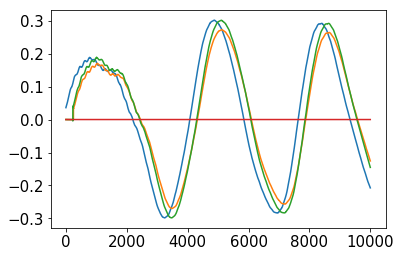

In [10]:
extent = 10000

plt.plot(data[:extent])
plt.plot(rec_signal[0,:extent])
plt.plot(rec_signal[1,:extent])
plt.plot(0*rec_signal[1,:extent])
plt.show()

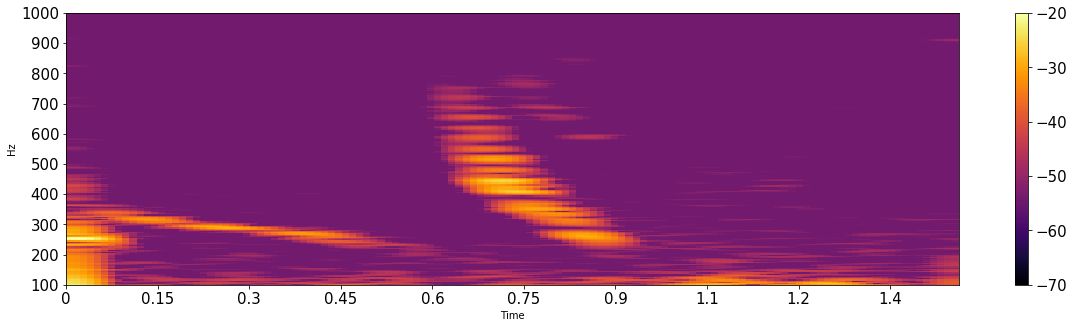

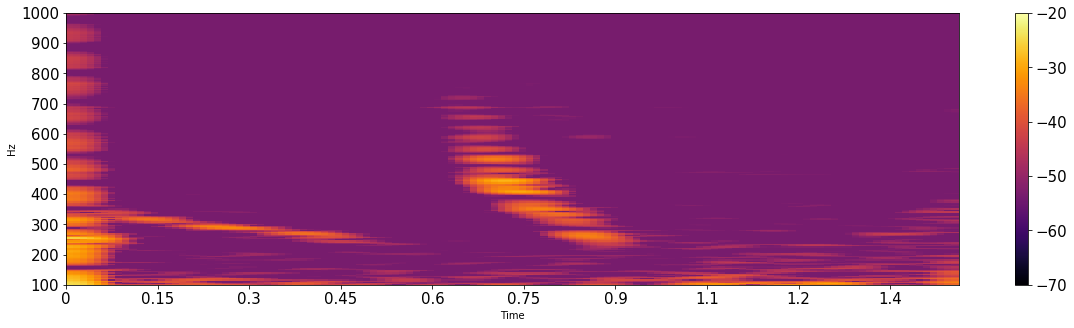

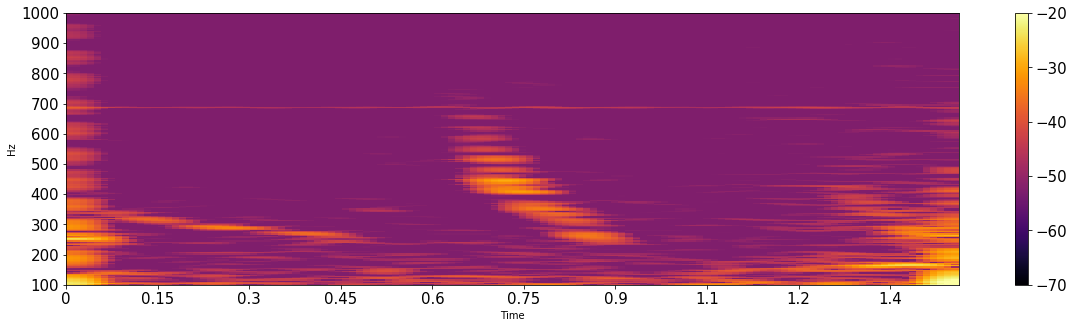

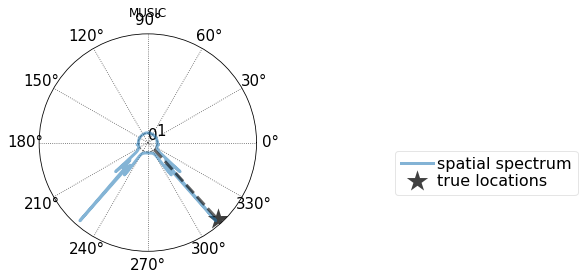

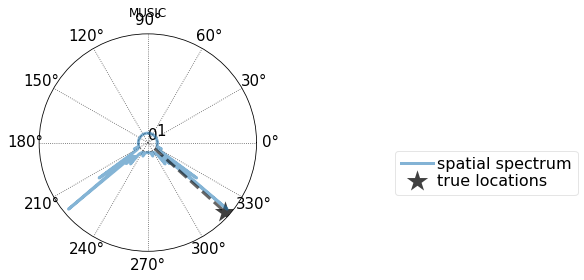

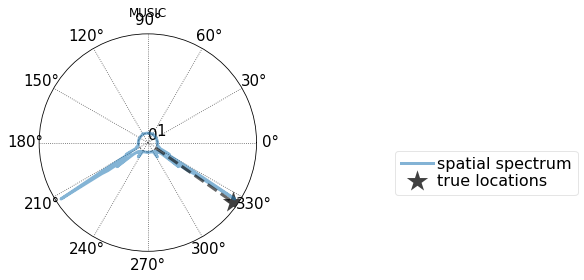

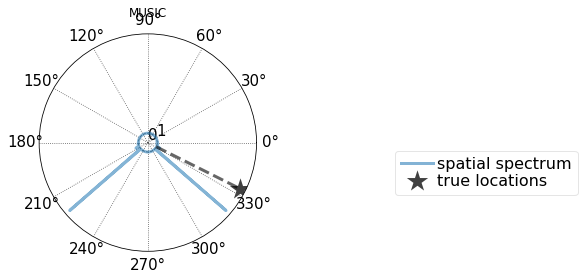

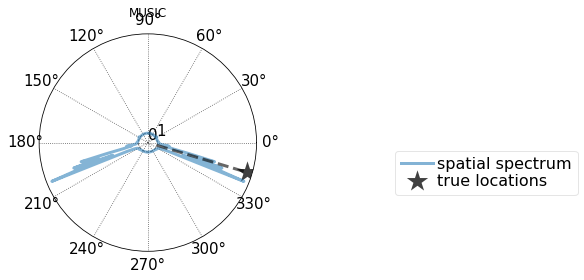

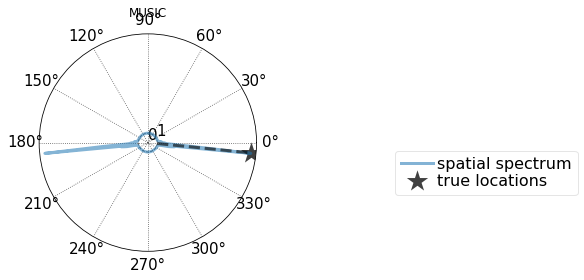

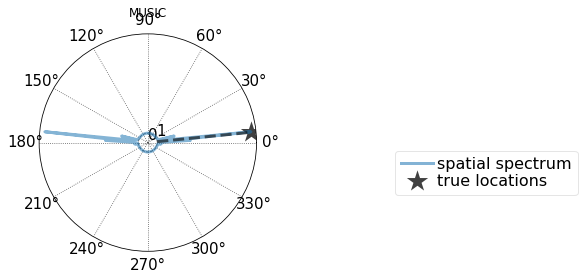

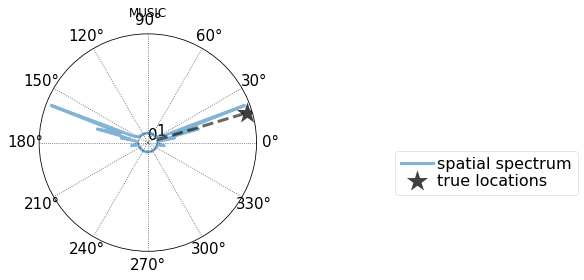

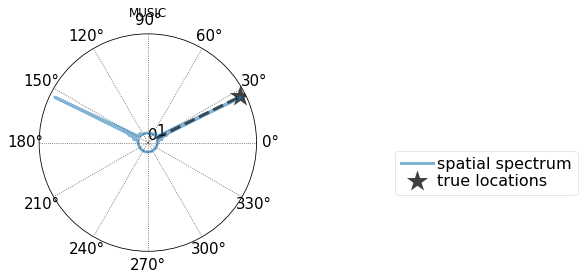

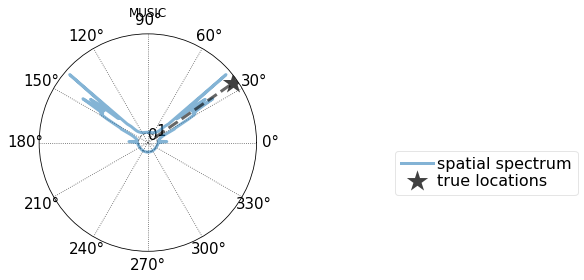

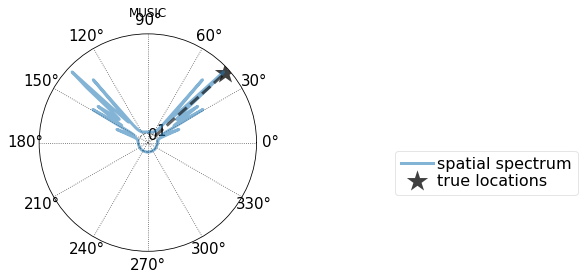

In [21]:
file_name = '../recordings/180910_142834.wav'
algo_name = 'MUSIC'
hot_sig = 1

for y_loc in range(2,13):
    room_dim = [10000, 10000, 10000]
    r_source=np.c_[[5005, y_loc, 5000]]
    r_rec=np.c_[
        [5000, 7, 5000],  # mic 1
        [5000, 8, 5000],  # mic 2
        ]

    rx_center = r_rec.mean(axis=1, keepdims=True)
    v = r_source-rx_center
    base_vec = np.c_[[1,0,0]]
    c = np.dot(v.T, base_vec)/np.linalg.norm(base_vec)/np.linalg.norm(v) # -> cosine of the angle
    angle = np.arccos(np.clip(c, -1, 1)) # if you really want the angle
    azimuth = [np.sign(v[1])*angle[0,0]]

    # reshape into 1d numpy array
    r_source = r_source[:,0]

    fs = 44100
    data, fs = read_sound(file_name, time=[285, 287])
#     data = np.sin(2*np.pi*500*(1./fs)*np.arange(data.shape[0]))

    rec_signal = sim_room(data, fs, absorption=0.9, r_source=r_source, r_rec=r_rec, room_dim=room_dim)

    rec_signal_noised = add_noise(rec_signal, SNR=0, noise_id=(2,3), noise_location_doc='silence_180910_142834.txt')
    clim = (-70,-20)

    if hot_sig:
        spect(data/np.sqrt(np.sum(data**2)), fs, figsize=[20,5])
        plt.colorbar()
        plt.clim(clim)

        spect(rec_signal_noised[0,:], fs, figsize=[20,5])
        plt.colorbar()
        plt.clim(clim)

        spect(rec_signal_noised[1,:], fs, figsize=[20,5])
        plt.colorbar()
        plt.clim(clim)
        hot_sig = 0

    nfft = 1024*8
    overlap_ratio = 1
    X = np.array([produce_spect_for_music(channel_sig, nfft=nfft, overlap_ratio=overlap_ratio, fft_type='stft')
                  for channel_sig in rec_signal_noised])

    doa = locate_source(X[:, :, 5:7], r_rec, fs, nfft, algo_name, freq_range = [300., 800.])
    plot_doa(doa, azimuth, algo_name)
